# Predict with pre-trained models

This is a demo for predicting with a pre-trained model on the full imagenet dataset, which contains over 10 million images and 10 thousands classes. For a more detailed explanation, please refer to [predict.ipynb](https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb).

We first load the pre-trained model.

In [ ]:
import os, wget
import mxnet as mx
import skimage.io
def download(url,prefix=''):
    filename = prefix+url.split("/")[-1]
    if not os.path.exists(filename):
        wget.download(url,filename)

path='http://data.mxnet.io/models/imagenet-11k/'
download(path+'resnet-152/resnet-152-symbol.json', 'full-')
download(path+'resnet-152/resnet-152-0000.params', 'full-')
download(path+'synset.txt', 'full-')

with open('full-synset.txt', 'r') as f:
    synsets = [l.rstrip() for l in f]

sym, arg_params, aux_params = mx.model.load_checkpoint('full-resnet-152', 0)

# Choose Hardware 
CPU or GPU

In [ ]:
context = mx.cpu(0)
#context = mx.gpu(0)

In [ ]:
mod = mx.mod.Module(symbol=sym, context=context)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
mod.set_params(arg_params, aux_params)

Next we define the function to obtain an image by a given URL and the function for predicting.

In [ ]:
%matplotlib inline
import skimage
import scipy
import matplotlib
matplotlib.rc("savefig", dpi=100)
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

class color:
   BLUE = '\033[94m'
   END = '\033[0m'


def get_image(url, show=True):
    filename = url.split("/")[-1]
    wget.download(url,filename)
    img = skimage.io.imread(filename)
    if img is None:
        print('failed to download ' + url)
    if show:
        plt.imshow(img)
        plt.axis('off')
    return filename

def predict(filename, mod, synsets):
    img = skimage.io.imread(filename)
    if img is None:
        return None
    img = scipy.misc.imresize(img,(224,224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) 
    img = img[np.newaxis, :] 
    
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    prob = np.squeeze(prob)

    a = np.argsort(prob)[::-1]    
    for pred_idx in a[0:5]:
        if pred_idx == a[0]:
            prefix = color.BLUE  
            suffix = color.END
        else:
            prefix = suffix = ""
        print(prefix + 'probability={0:.2}, class={1}'.format(prob[pred_idx],synsets[pred_idx]) + suffix)
    

We are able to classify an image and output the top predicted classes. 

In [ ]:
url = 'http://writm.com/wp-content/uploads/2016/08/Cat-hd-wallpapers.jpg'
predict(get_image(url), mod, synsets)

probability=0.63, class=n02088364 beagle
probability=0.047, class=n00452864 beagling
probability=0.024, class=n02778669 ball
probability=0.017, class=n01322604 puppy
probability=0.015, class=n02087122 hunting dog


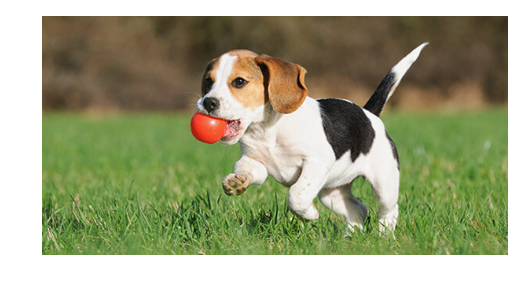

In [44]:
url = 'https://images-na.ssl-images-amazon.com/images/G/01/img15/pet-products/small-tiles/23695_pets_vertical_store_dogs_small_tile_8._CB312176604_.jpg'
predict(get_image(url), mod, synsets)